<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/bin_clss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# # clip cleaned
# # https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
!gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
!unzip /content/gsv.zip -d /
!rm -R /content/gsv/.ipynb_checkpoints
!rm -R /content/gsv/01/.ipynb_checkpoints
!rm -R /content/gsv/02/.ipynb_checkpoints
!rm -R /content/gsv/03/.ipynb_checkpoints
!rm -R /content/gsv/04/.ipynb_checkpoints
!rm -R /content/gsv/05/.ipynb_checkpoints
!rm -R /content/gsv/06/.ipynb_checkpoints

# # gsv 70k
# # https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
# !gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
# !unzip /content/gsv.zip -d /

# # # !ls
# !ls -a /content/gsv70k
# !rm -R /content/gsv70k/.ipynb_checkpoints
# # # !rm -R /content/gsv/06/.ipynb_checkpoints

# # https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



In [ ]:
# @title symbolic link
dir='/content/gsv/'
sym_link = '/content/sym/'

import os
if not os.path.exists(sym_link): os.makedirs(sym_link)

f1 = lambda x: dir+str(x).zfill(2)
f2 = lambda x: sym_link+str(x).zfill(2)
# print([f(x) for x in range(1,7) for f in (f1,f2)])
i, j = 5,6 # 5,6

# ls -l {}
sh = '''
rm {} {} {} {} {} {}
ln -s {} {}
ln -s {} {}
'''.format(*[f2(x) for x in range(1,7)], *[f(x) for x in [i,j] for f in (f1,f2)])

# print(sh)

with open('script.sh', 'w') as file:
  file.write(sh)
!bash script.sh

def make_sym(i, j):
    sh = '''
    rm {} {} {} {} {} {}
    ln -s {} {}
    ln -s {} {}
    '''.format(*[f2(x) for x in range(1,7)], *[f(x) for x in [i,j] for f in (f1,f2)])
    with open('script.sh', 'w') as file:
        file.write(sh)
    !bash script.sh


# combi = torch.combinations(torch.arange(0,6), with_replacement=True)
# i, j = 1,2 # 5,6
# datai = datasets.ImageFolder(dir+'/'+str(i).zfill(2), transform=None)
# # dataj = datasets.ImageFolder(dir+'/'+str(j).zfill(2), transform=None)
# # train_bin_set = torch.utils.data.ConcatDataset([datai, dataj])

# # construct the full dataset
# dataset = datasets.ImageFolder(dir, transform=None)
# # select the indices of all other folders
# # idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] != dataset.class_to_idx['class_s']]
# # build the appropriate subset
# idx=[i,j]
# # data = torch.utils.data.Subset(dataset, idx)

# dataset=None

# indices = np.arange(data_size)
# np.random.shuffle(indices)
# split_index = int(np.floor(0.9 * data_size))
# train_idx, test_idx = indices[:split_index], indices[split_index:]
# train_data = torch.utils.data.Subset(data, train_idx)
# test_data = torch.utils.data.Subset(data, test_idx)
# targets = np.array(data.targets)


# print(data.targets)
# indices[np.where[data.targets==i or data.targets==j]]





In [2]:
# @title data weighted
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/google_street_view'
# dir='/content/gsv70k'
# dir='/content/gsv'
dir='/content/sym'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)

torch.manual_seed(0)

# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/
data_size = len(data)
indices = np.arange(data_size)
np.random.shuffle(indices)
split_index = int(np.floor(0.9 * data_size))
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_data = torch.utils.data.Subset(data, train_idx)
test_data = torch.utils.data.Subset(data, test_idx)
targets = np.array(data.targets)
train_targets = targets[train_idx]
test_targets = targets[test_idx]

from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform
        self.datasize = len(self.dataset)

    def __len__(self):
        return self.datasize
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)

batch_size = 16 # 64

# https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset
from collections import Counter
class_count = torch.tensor(list(Counter(data.targets).values()))
weights=1./class_count
# weights=sum(class_count)/class_count
# https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
train_weight = weights[train_targets]
test_weight = weights[test_targets]
# train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
# test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, 10000)
test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, 1000)
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None
num_batches=int(np.ceil(len(train_loader)/batch_size))

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None
# print(labels)

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None

# for x in [5,6]:
#     allfiles = os.listdir('/content/sym/0'+str(x)+'/')
#     print(x,len(allfiles))


def make_loader():
    data = datasets.ImageFolder(dir, transform=None)
    data_size = len(data)
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    split_index = int(np.floor(0.9 * data_size))
    train_idx, test_idx = indices[:split_index], indices[split_index:]
    train_data = torch.utils.data.Subset(data, train_idx)
    test_data = torch.utils.data.Subset(data, test_idx)
    targets = np.array(data.targets)
    train_targets = targets[train_idx]
    test_targets = targets[test_idx]

    # train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
    train_data = DatasetWrap(train_data, transform)
    test_data = DatasetWrap(test_data, transform)

    class_count = torch.tensor(list(Counter(data.targets).values()))
    weights=1./class_count
    # weights=sum(class_count)/class_count
    train_weight = weights[train_targets]
    test_weight = weights[test_targets]
    # train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
    # test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
    train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, 10000)
    test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, 1000)
    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
    data, train_data, test_data = None, None, None
    num_batches=int(np.ceil(len(train_loader)/batch_size))
    return train_loader, test_loader



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
num_ftrs = model.fc.in_features
model.fc = nn.Sequential( # og
    # nn.Linear(num_ftrs, 2, bias=False),
    nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Linear(128, 2),
    nn.Softmax(dim=1),
    )

# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
model = torch.compile(model.to(device),mode='max-autotune')

def make_model():
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential( # og
        nn.Linear(num_ftrs, 2, bias=False),
        # nn.Linear(num_ftrs, 128), nn.ReLU(),
        # nn.Linear(128, 2),
        nn.Softmax(dim=1),
        )
    model = torch.compile(model.to(device),mode='max-autotune')
    return model



In [ ]:
# @title try

# # check model's input and output dimensions are correct
x0 = torch.rand(16, 3, 400, 640, device=device)
x1 = torch.rand(16, 3, 400, 640, device=device)
model.eval()
pred0 = model(x0)
pred1 = model(x1)
print(pred0.shape)
print(torch.cat((pred0, pred1),).shape)

pred = bincls(torch.cat((pred0, pred1),-1))

# targets = torch.randint(0,6,(16,), device=device)
targets = torch.randint(0,3,(16,), device=device)/2
print(targets)



In [6]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    # size = len(dataloader.dataset)
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            pred = model(sx) # [16, 512]
            loss = loss_fn(pred, sy)

            # modules = [module for k, module in model._modules.items()]
            # pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing for resnet and inception only
            # # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)
            # loss = loss_fn(pred, sy) # /4 to scale by gradient accumulation_steps

        scaler.scale(loss).backward()
        # if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        # if (batch) % (size//(10* len(y))) == 0:
        # if batch % (size//10) == 0:
        if batch % ((dataloader.sampler.num_samples/dataloader.batch_size)//10) == 0:
            loss, current = loss.item()/len(y), batch * len(x)
            # if verbose: print(f"loss: {loss:>7f} [{current:>5d}/{size*len(y):>5d}]")
            if verbose: print(f"loss: {loss:>7f} [{current:>5d}/{dataloader.sampler.num_samples:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            sx, sy = x.to(device), y.to(device)
            pred = model(sx)
            # loss = loss_fn(pred, y)
            test_loss += loss_fn(pred, sy).item()
            correct += (pred.argmax(1) == sy).type(torch.float).sum().item()
    # test_loss /= num_batches
    # correct /= num_batches*len(y)
    test_loss /= dataloader.sampler.num_samples
    correct /= dataloader.sampler.num_samples
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 0.043136 [    0/10000]
loss: 0.043326 [  992/10000]
loss: 0.044230 [ 1984/10000]
loss: 0.041912 [ 2976/10000]
loss: 0.033916 [ 3968/10000]
loss: 0.025271 [ 4960/10000]
loss: 0.028223 [ 5952/10000]
loss: 0.042127 [ 6944/10000]
loss: 0.042969 [ 7936/10000]
loss: 0.043470 [ 8928/10000]
loss: 0.042439 [ 9920/10000]


<ipython-input-10-b775ef6b3df7>:49: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


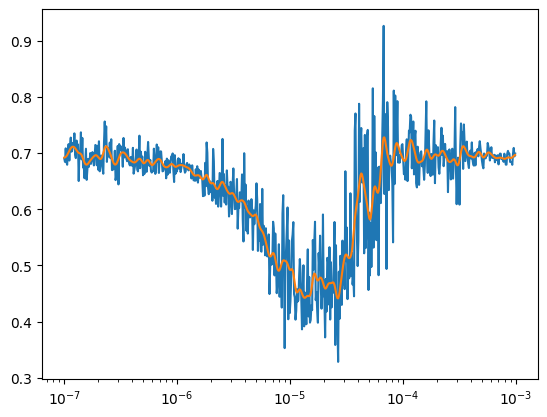

625


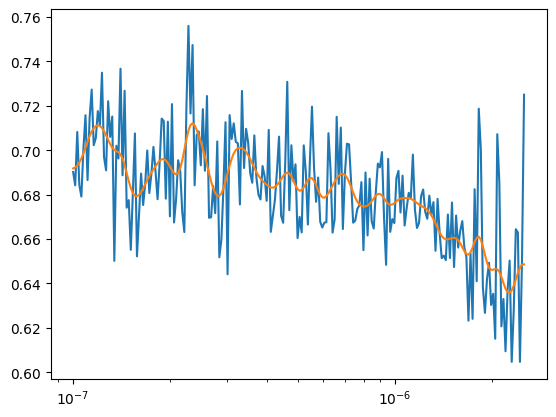

In [10]:
# @title LR range test
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs

pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding

epochs=1#5
min_lr= 1e-7
max_lr= 1e-3 # 1e-2
# 152: 1e-7 - 1e-4      result 3e-7 - 3e-6

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss() # loss with sigmoid, so model no need sigmoid

model.load_state_dict(torch.load("lr.pth"))
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)

# num_batches=int(np.ceil(len(test_loader)/batch_size))
num_batches=len(train_loader)
# num_batches=len(test_loader)

# total_steps=int(np.ceil(num_batches/4)*epochs)
total_steps=int(num_batches*epochs)

# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps) # for scheduler step every optimizer step
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
train_lst, test_lst=[],[]
lr_list=np.ones(total_steps)*min_lr*gamma**np.arange(total_steps)
# gamma = np.exp(np.log(max_lr/min_lr)/(total_steps*4)) # total_steps*4 bec grad accumulation, loss step 4x per lr step
# lr_list=np.ones(total_steps*4)*min_lr*gamma**np.arange(total_steps*4)


for i in range(epochs):
    # train_ls = strain(test_loader, model, loss_fn, optimizer, scheduler)    
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)    
    train_lst.extend(train_ls)


# https://stackoverflow.com/a/53472966/13359815
from scipy.ndimage.filters import gaussian_filter1d
train_lstsm = gaussian_filter1d(train_lst, sigma=3)
end=200

import matplotlib.pyplot as plt
plt.plot(lr_list, train_lst)
plt.plot(lr_list, train_lstsm)
# plt.plot(lr_list[:end], train_lst[:end])
# plt.plot(lr_list[:end], train_lstsm[:end])
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()

print(len(lr_list))
start, end = 20, 220
plt.plot(lr_list[:end], train_lst[:end])
plt.plot(lr_list[:end], train_lstsm[:end])
plt.xscale('log')
plt.show()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

Epoch 1
-------------------------------
1.0000000000000006e-06


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-06-06 06:11:55,667] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode


loss: 0.709067 [    0/10000]
loss: 0.686675 [  992/10000]
loss: 0.666775 [ 1984/10000]
loss: 0.632125 [ 2976/10000]
loss: 0.591286 [ 3968/10000]
loss: 0.424638 [ 4960/10000]
loss: 0.434963 [ 5952/10000]
loss: 0.315851 [ 6944/10000]
loss: 0.326113 [ 7936/10000]
loss: 0.454464 [ 8928/10000]
loss: 0.479850 [ 9920/10000]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-06-06 06:14:05,594] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-06-06 06:14:17,756] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 50.6%, Avg loss: 0.050425
Epoch 2
-------------------------------
1.2989902917417341e-05


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 0.323248 [    0/10000]
loss: 0.441899 [  992/10000]
loss: 0.448893 [ 1984/10000]
loss: 0.557463 [ 2976/10000]
loss: 0.659038 [ 3968/10000]
loss: 0.688088 [ 4960/10000]
loss: 0.456650 [ 5952/10000]
loss: 0.761818 [ 6944/10000]
loss: 0.635005 [ 7936/10000]
loss: 0.506257 [ 8928/10000]
loss: 0.560849 [ 9920/10000]
Accuracy: 63.9%, Avg loss: 0.040164
Epoch 3
-------------------------------
2.9130953467035865e-05
loss: 0.587614 [    0/10000]
loss: 0.431147 [  992/10000]
loss: 0.464729 [ 1984/10000]
loss: 0.531097 [ 2976/10000]
loss: 0.533026 [ 3968/10000]
loss: 0.648209 [ 4960/10000]
loss: 0.578071 [ 5952/10000]
loss: 0.600594 [ 6944/10000]
loss: 0.466240 [ 7936/10000]
loss: 0.546003 [ 8928/10000]
loss: 0.539897 [ 9920/10000]
Accuracy: 64.5%, Avg loss: 0.042324
Epoch 4
-------------------------------
2.27294097074691e-05
loss: 0.845612 [    0/10000]
loss: 0.370855 [  992/10000]
loss: 0.427392 [ 1984/10000]
loss: 0.520629 [ 2976/10000]
loss: 0.510882 [ 3968/10000]
loss: 0.353624 [ 4960

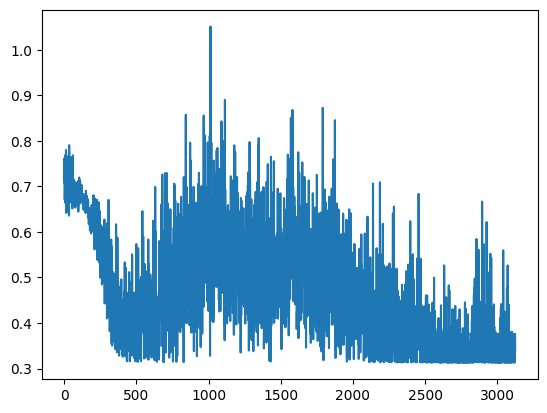

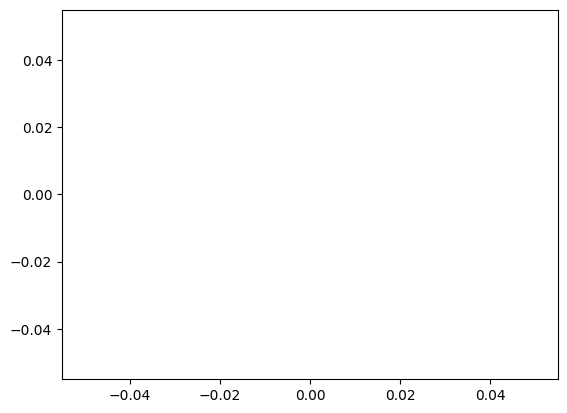

In [5]:
# @title wwwwwwwww
import time
start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()

base_lr, max_lr = 1e-6, 3e-5 # 1e-5, 1e-3 #0.5#
# res152 3e-7, 3e-6
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

epochs = 5 #5 20
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), optim_bits=8)
# 152 1e-5
# cnn 3e-4

div_factor = max_lr/base_lr
num_batches=len(train_loader)
total_steps=int(num_batches*epochs)+1
# total_steps=int(np.ceil(num_batches/4)*epochs)+1 # +1 to excluse uptick at the end of onecycle
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


# for x in range(int(num_batches)*1):
#     scheduler.step()


for t in range(0,epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    correct, test_loss = test(test_loader, model, loss_fn)
    train_lst.extend(train_ls)
    # test_lst.append(test_loss)
    # acc_lst.append(correct)

    # checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
    # 'epoch': t,
    # 'model': model.state_dict(),
    # 'optimizer': optimizer.state_dict(),
    # 'lr_sched': scheduler}
    # # torch.save(checkpoint, 'checkpoint.pth')
    # torch.save(checkpoint, '/content/drive/MyDrive/frame/resnet1522.pth')
    # torch.save(model.state_dict(), "model.pth")

print("Done!")

end = time.time()
print("time: ",end - start)

# print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst.cpu().numpy())
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()


torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# res18 1e-6, 3e-5 nobias sig,crossentropy cls56 sampler10k retrain 54.4%, 575s
# res18 nobias cls56 sampler10k 55.1%, 598s
# res18 1e-6, 3e-5 2layer,bias cls56 sampler10k 56.0%, 615





In [27]:
correct, test_loss = test(test_loader, model, loss_fn)
print(correct, test_loss)

Accuracy: 53.3%, Avg loss: 0.048154
0.533 0.048153585374355316


In [ ]:
# @title bin clss train
import time
start = time.time()
loss_fn = nn.CrossEntropyLoss()

base_lr, max_lr = 1e-6, 3e-5 # 1e-5, 1e-3 #0.5#
# 1e-5:1e-4

epochs = 5 #5 20

model_dict={}
combi = torch.combinations(torch.arange(0,6), with_replacement=True)
for i, j in combi:
    make_sym(i, j)
    train_loader, test_loader = make_loader()
    model = make_model()
    optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)

    div_factor = max_lr/base_lr
    num_batches=len(train_loader)
    total_steps=int(num_batches*epochs)+1
    # total_steps=int(np.ceil(num_batches/4)*epochs)+1 # +1 to excluse uptick at the end of onecycle
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=True,)

    for t in range(0,epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        lr=optimizer.param_groups[0]["lr"]
        print(lr)
        train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler,verbose=False)
        correct, test_loss = test(test_loader, model, loss_fn)
        train_lst.extend(train_ls)
    model_dict['model'+str(i)+str(j)] = model.state_dict()
    torch.save(model_dict, "bin_models.pth")



print("Done!")

end = time.time()
print("time: ",end - start)


In [ ]:
# @title confusion matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

model.eval()
y_true, y_pred = [], []
img,label=next(iter(test_loader))
img=
with torch.no_grad():
    # print(img.shape) # [16, 3, 400, 640]
    img=img.to(device)
    pimg = model(img)
    for X, y in test_loader:
        x, y = X.to(device), y.to(device)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['1','2','3','4','5','6',], yticklabels=['1','2','3','4','5','6',])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: ignored

In [ ]:
# @title save

# from google.colab import drive
# drive.mount('/content/drive')

# # pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res55.pth'
# pth='/content/drive/MyDrive/frame/resnet152.pth'

torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# # model.load_state_dict(torch.load("model.pth"))





# # https://drive.google.com/file/d/1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv/view?usp=share_link
# !gdown 1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv -O resnet152.pth

# # t, modelsd, optimsd, scheduler = torch.load('/content/drive/MyDrive/frame/resnet152.pth').values()
# t, modelsd, optimsd, scheduler = torch.load('/content/resnet152.pth').values()
# model.load_state_dict(modelsd)
# # optimizer.load_state_dict(optimsd)



# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
